In [32]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


## Define growing degree days
Growing degree days are calculated as the yearly sum of
$$\frac{T_{min}+T_{max}}{2} - T_{base}$$
where $T_{base}$ can be set according to the crop type. Here, we use method 1 as described by McMaster & Wilhelms (1997), where the average temperature $\frac{T_{min}+T_{max}}{2}$ is set equal to the base temperature if it is lower than the base temperature, with the possibility to add an upper temperature threshold $T_{upper}$ above which the average temperature is set equal to the upper temperature threshold (i.e. assuming that a higher temperature does not lead to increased growth).

McMaster, G. S., & Wilhelm, W. W. (1997). Growing degree-days: one equation, two interpretations. Agricultural and forest meteorology, 87(4), 291-300.

In [33]:
def growing_degree_days(da_list, tbase, tupper=None):
    # Calculate growing degree days
    # Input: minimum temperature and maximum temperature, base temperature, upper temperature
    # NB! All units should be in Kelvin
    tmin = da_list[0] # Minimum temperature
    tmax = da_list[1] # Maximum temperature

    n_lats = len(tmin.lat)
    n_lons = len(tmin.lon)
    n_years = int(len(tmin.time)/365)

    growing_degree_days = np.zeros((n_lats, n_lons, n_years))

    for lat in range(n_lats):
        for lon in range(n_lons):
            for year in range(n_years):
                tmin_i = tmin.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365)) # Choose grid box and year
                tmax_i = tmax.isel(lat=lat, lon=lon, time=slice(year*365,(year+1)*365)) # Choose grid box and year

                t_avg = (tmin_i.values + tmax_i.values)/2.

                # Set average temperature equal to base temperature if it is lower than this sum
                t_avg = t_avg*(t_avg >= tbase) + np.ones(len(t_avg))*tbase*(t_avg < tbase)
                
                if tupper:
                    # Set average temperature equal to upper temperature if it is higher than this sum
                    t_avg = t_avg*(t_avg <= tupper) + np.ones(len(t_avg))*tupper*(t_avg > tupper)

                temp_diff = t_avg - tbase
                GDD = np.sum(temp_diff)

                growing_degree_days[lat, lon, year] = GDD
    
    return growing_degree_days

In [34]:
# Define dataset specifics

model_scenario_name = 'NorESM2-LM_ssp126' # Choose a model and SSP scenario
area_name = 'norway' # Choose an area

# Defines start and end of time slice by picking 20 years before and 20 years after abrupt SPG cooling
if model_scenario_name == 'NorESM2-LM_ssp126':
    start_time = '2015-01-01'; end_time = '2055-01-01'
    time_array = np.arange(2015, 2055, 1)
elif model_scenario_name == 'CESM2-WACCM_ssp126':
    start_time = '2020-01-01'; end_time = '2060-01-01'
    time_array = np.arange(2020, 2060, 1)
elif model_scenario_name == 'MRI-ESM2_ssp245':
    start_time = '2020-01-01'; end_time = '2060-01-01'
    time_array = np.arange(2020, 2060, 1)
else:
    print("This dataset is not considered in the current study, but can be added to the analysis")

if area_name == 'norway':
    southern_lat = 57; northern_lat = 72
    western_lon = 2.5; eastern_lon = 33
elif area_name == 'germany':
    southern_lat = 46.5; northern_lat = 55.5
    western_lon = 5; eastern_lon = 15
elif area_name == 'global':
    southern_lat = -90; northern_lat = 90
    western_lon = 0; eastern_lon = 360
else:
    print("This area is not predefined in the current study, but can be added to the analysis")

data_folder = '../CMIP6_data/' # Folder where downloaded CMIP6 data is stored
save_folder = '../climatic_indices/' # Folder where climate indices should be saved
os.makedirs(save_folder, exist_ok=True) 


# Load maximum daily temperature data

files = glob.glob(data_folder+'tasmax_day_'+model_scenario_name+'*')
files.sort()
tasmax = xr.open_mfdataset(files)

tmax = tasmax.tasmax.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(western_lon, eastern_lon), 
                        time=slice(start_time, end_time))

tmax.load()

# Load minimum daily temperature data

files = glob.glob(data_folder+'tasmin_day_'+model_scenario_name+'*')
files.sort()
tasmin = xr.open_mfdataset(files)

tmin = tasmin.tasmin.sel(lat=slice(southern_lat, northern_lat), 
                        lon=slice(western_lon, eastern_lon), 
                        time=slice(start_time, end_time))

tmin.load()

<xarray.DataArray 'tasmin' (time: 14601, lat: 8, lon: 13)> Size: 6MB
array([[[273.3614 , 271.6733 , 269.38773, ..., 262.42883, 262.4719 ,
         262.62924],
        [273.06244, 269.13956, 259.00912, ..., 268.25894, 264.5443 ,
         262.66522],
        [273.70053, 268.65912, 256.0441 , ..., 262.61197, 263.0432 ,
         261.72565],
        ...,
        [271.24426, 272.30853, 272.85446, ..., 258.11313, 256.91815,
         256.5043 ],
        [269.452  , 270.92758, 271.97177, ..., 261.16495, 262.1215 ,
         264.3928 ],
        [268.0876 , 270.1765 , 269.54572, ..., 268.09714, 269.542  ,
         269.95227]],

       [[273.7263 , 272.46072, 270.1581 , ..., 262.43698, 261.91577,
         262.4874 ],
        [273.6518 , 270.5034 , 259.78983, ..., 268.45425, 263.24603,
         258.91605],
        [274.24197, 270.16592, 258.59772, ..., 261.72455, 257.24796,
         254.29459],
...
        [272.28632, 274.36877, 274.70578, ..., 260.6846 , 262.0461 ,
         265.70886],
        [269.69995, 272.24713, 273.79416, ..., 257.1634 , 263.9845 ,
         267.63345],
        [267.2852 , 270.2222 , 272.7994 , ..., 269.58737, 269.53616,
         269.14706]],

       [[277.49347, 276.84662, 276.51312, ..., 265.92093, 263.48846,
         259.90463],
        [277.13364, 274.57626, 268.16193, ..., 267.33005, 260.6958 ,
         261.84457],
        [275.71158, 271.39877, 260.522  , ..., 262.24658, 261.28616,
         254.01425],
        ...,
        [272.51358, 274.58426, 274.1952 , ..., 262.1167 , 262.2105 ,
         258.75092],
        [271.5211 , 274.18466, 274.4293 , ..., 262.7714 , 261.9295 ,
         265.48013],
        [270.50217, 273.80774, 274.00595, ..., 269.3773 , 269.81058,
         269.52658]]], dtype=float32)
Coordinates:
  * time     (time) object 117kB 2015-01-01 12:00:00 ... 2055-01-01 12:00:00
  * lat      (lat) float64 64B 57.79 59.68 61.58 63.47 65.37 67.26 69.16 71.05
  * lon      (lon) float64 104B 2.5 5.0 7.5 10.0 12.5 ... 25.0 27.5 30.0 32.5
    height   float64 8B 2.0
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Minimum Near-Surface Air Temperature
    comment:        minimum near-surface (usually, 2 meter) air temperature (...
    units:          K
    original_name:  TREFHTMN
    cell_methods:   area: mean time: minimum
    cell_measures:  area: areacella
    history:        2019-12-06T14:55:16Z altered by CMOR: Treated scalar dime...

In [35]:
# Choose which variable to calculate

variable_name = 'GDD'
unit = 'Kelvin'
description = 'Growing degree days'
input_values = [tmin, tmax]
tbase = 273.15 + 5
tupper = 273.15 + 30
values = growing_degree_days(input_values, tbase, tupper)

# Save data as netcdf file

ds = xr.Dataset(
    data_vars=dict(
        variable=(["lat", "lon", "time"], values)
    ),
    coords=dict(
        lat=input_values[0].lat.values,
        lon=input_values[0].lon.values,
        time=time_array,
    ),
)

ds.time.attrs['units'] = 'year'
ds.lat.attrs['description'] = 'latitude'
ds.lon.attrs['description'] = 'longitude'
ds = ds.rename_vars(dict(variable=variable_name))
ds[variable_name].attrs['units'] = unit
ds[variable_name].attrs['description'] = description

ds.to_netcdf(save_folder+variable_name+'_'+area_name+'_'+model_scenario_name+'.nc')
ds

<xarray.Dataset> Size: 34kB
Dimensions:  (lat: 8, lon: 13, time: 40)
Coordinates:
  * lat      (lat) float64 64B 57.79 59.68 61.58 63.47 65.37 67.26 69.16 71.05
  * lon      (lon) float64 104B 2.5 5.0 7.5 10.0 12.5 ... 25.0 27.5 30.0 32.5
  * time     (time) int64 320B 2015 2016 2017 2018 2019 ... 2051 2052 2053 2054
Data variables:
    GDD      (lat, lon, time) float64 33kB 1.541e+03 1.785e+03 ... 158.7 184.2

Text(0.5, 1.0, 'Change in growing degree days')

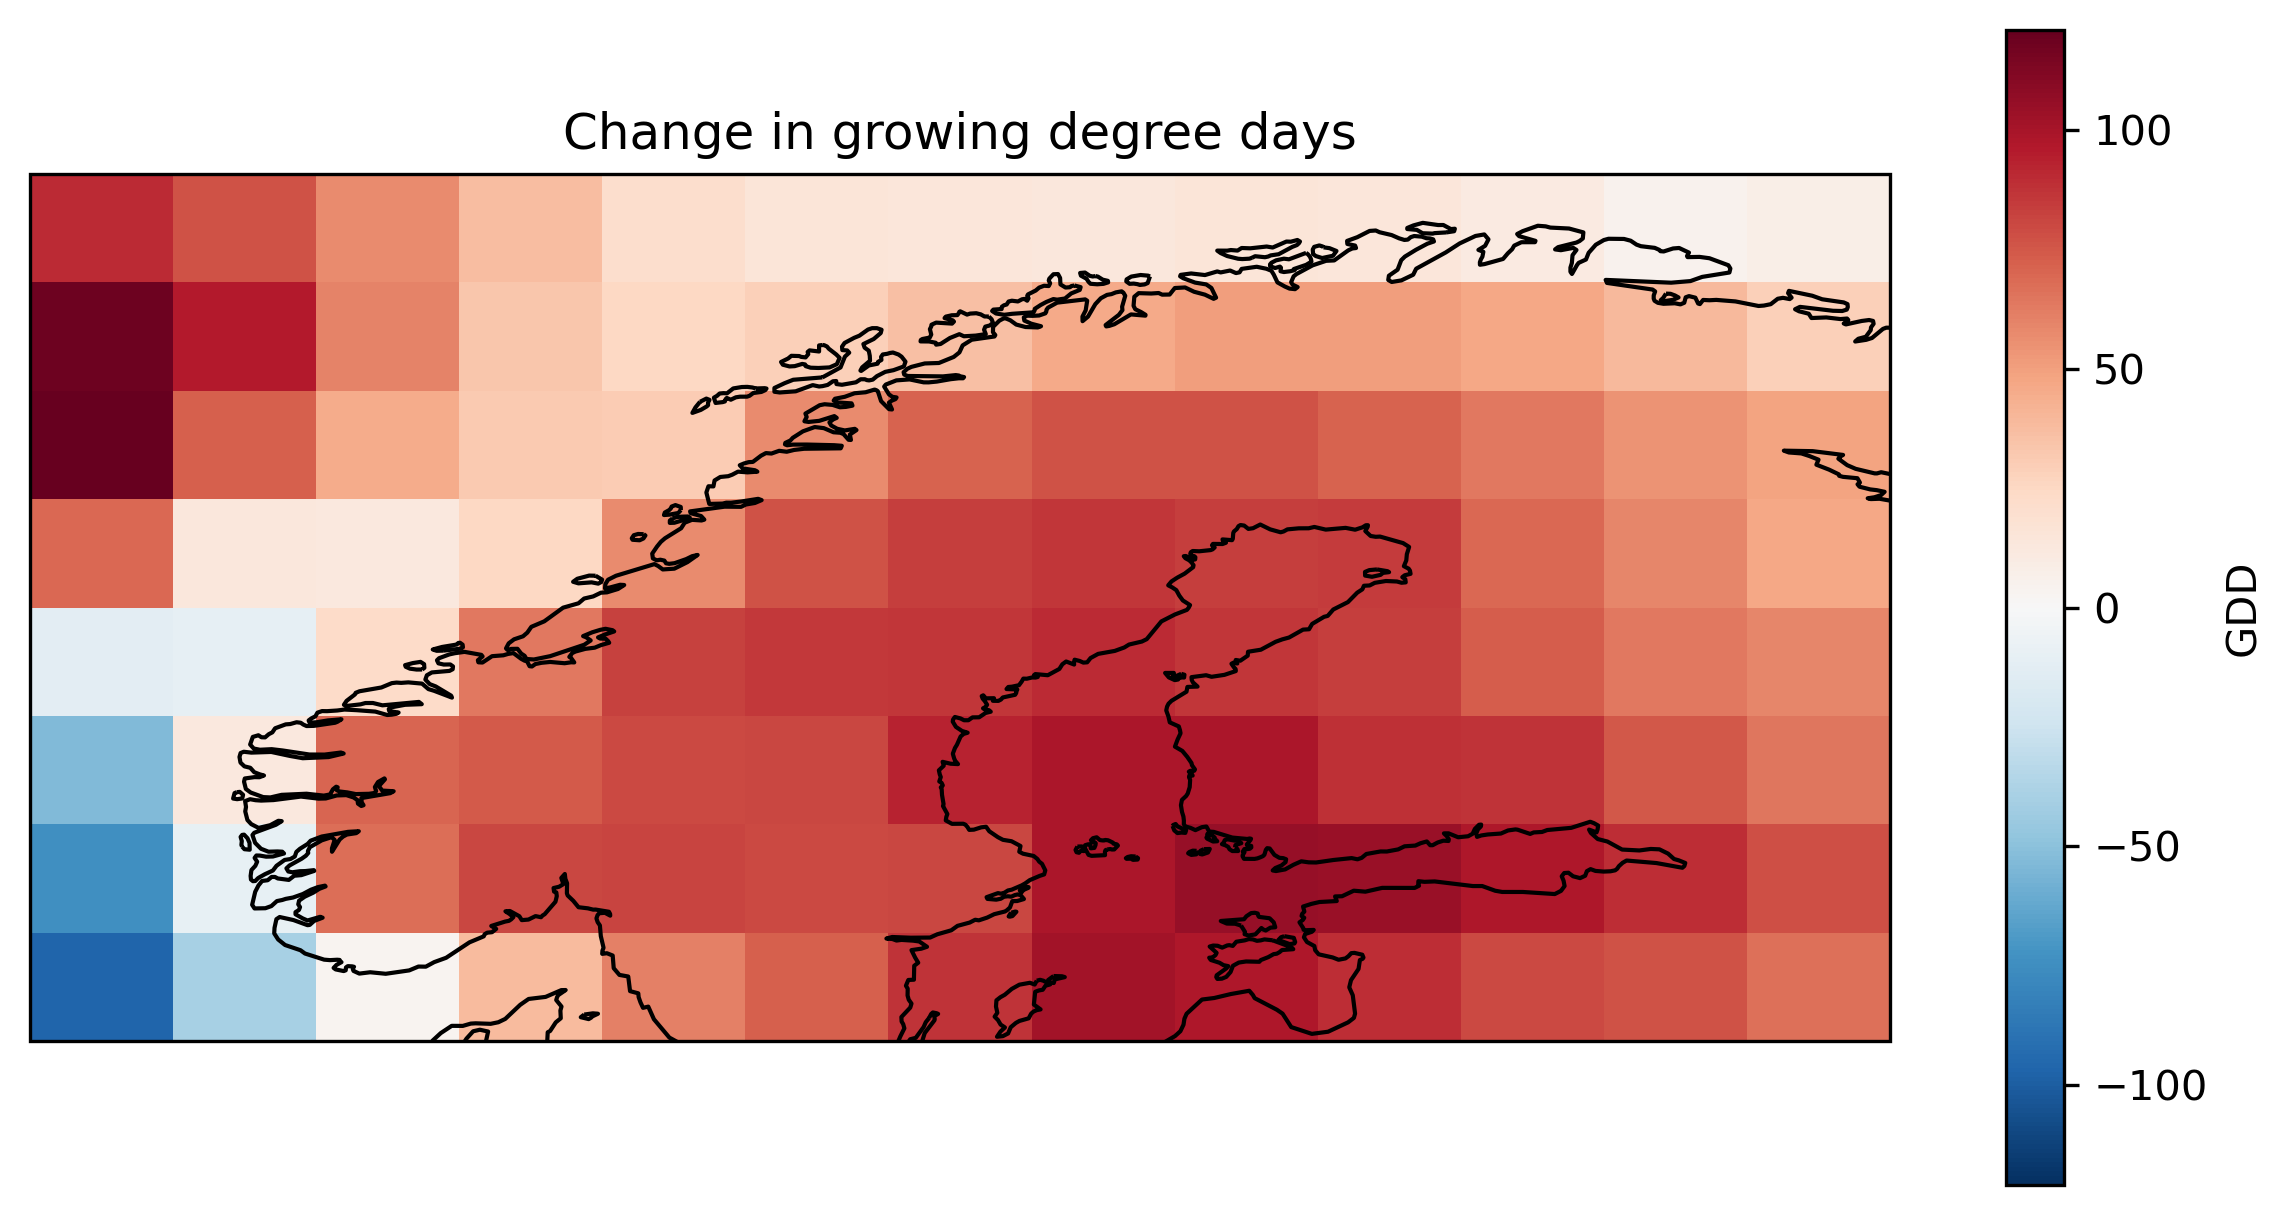

In [40]:
ds = xr.open_dataset(save_folder+variable_name+'_'+area_name+'_'+model_scenario_name+'.nc')
fig = plt.figure(1, figsize=(10,5),dpi=300)
ax = plt.subplot(1,1,1, projection=ccrs.PlateCarree())
diff = ds[variable_name].isel(time=slice(20,40)).mean("time") - ds[variable_name].isel(time=slice(0,20)).mean("time")
map = diff.plot(ax=ax, 
                transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_title("Change in growing degree days")